In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns

In [2]:
list_of_architectures = [
    "VGG16",
    "VGG19",
    "ResNet101V2",
    "ResNet152V2",
    "InceptionV3",
    "MobileNet",
    "MobileNetV2",
    "DenseNet121",
    "DenseNet169",
    "DenseNet201"
    
]

In [3]:
list_of_classifiers = [
    "RF"
]

In [4]:
list_of_size = [
    128,
    256
]

In [5]:
layer = "last_layer"

In [6]:
preprocessing_technique = "smote"

In [7]:
output_folder = "output"
analysis_output =  "../" + output_folder + "/" + layer + "_" + preprocessing_technique + "_binary_RF_128_256.csv"

In [8]:
def getData(model, image_size):
    train_data_dir="../../feature_extractor/" + layer + "/" + str(image_size)+"/"
    test_data_dir="../../feature_extractor/" + layer + "/" + str(image_size)+"/"
    #print(os.listdir(train_data_dir))
    #print(os.listdir(test_data_dir))
    X_train=np.load(train_data_dir+model+"_train_images.npy")
    y_train=np.load(train_data_dir+"train_labels.npy")
    X_test=np.load(test_data_dir+model+"_test_images.npy")
    y_test=np.load(test_data_dir+"test_labels.npy")
    return X_train, y_train, X_test, y_test

In [9]:
def getBinaryData(model, image_size):
    X_train, y_train, X_test, y_test = getData(model, image_size)
    df_train_labels=pd.DataFrame(y_train, columns=["labels"])
    df_test_labels=pd.DataFrame(y_test, columns=["labels"])
    df_train_labels_binary=df_train_labels["labels"].apply(lambda x : 0 if x==11 else 1)
    df_test_labels_binary=df_test_labels["labels"].apply(lambda x : 0 if x==11 else 1)
    y_train_binary = df_train_labels_binary.to_numpy()
    y_test_binary = df_test_labels_binary.to_numpy()
    return X_train, y_train_binary, X_test, y_test_binary

In [10]:
def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        import itertools
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        #print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        #plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

In [20]:
def getClassificationReport(y_test_binary, prediction):
    test_labels=y_test_binary
    from sklearn import metrics
    balanced_accuracy = round(metrics.balanced_accuracy_score(y_test_binary, prediction),3)
    accuracy = round(metrics.accuracy_score(y_test_binary, prediction),3)
    precision = round(metrics.precision_score(y_test_binary, prediction, average='weighted'),3)
    recall = round(metrics.recall_score(y_test_binary, prediction, average='weighted'),3)
    f1_score = round(metrics.f1_score(y_test_binary, prediction, average='weighted'),3)
    
    
    from sklearn.metrics import confusion_matrix
    test_label_list=list(np.unique(y_test_binary))
    cnf_matrix = confusion_matrix(y_test_binary, prediction,labels=test_label_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(3,3))
    plot_confusion_matrix(cnf_matrix, classes=test_label_list,
                          title='Confusion matrix, without normalization')

    from sklearn import metrics
    
    accuracy = round(metrics.accuracy_score(test_labels, prediction),3)
    precision = round(metrics.precision_score(test_labels, prediction, average='weighted'),3)
    recall = round(metrics.recall_score(test_labels, prediction, average='weighted'),3)
    f1_score = round(metrics.f1_score(test_labels, prediction, average='weighted'),3)
    
    # Balanced
    balanced_accuracy = round(metrics.balanced_accuracy_score(test_labels, prediction),3)
    
    from sklearn.metrics import confusion_matrix
    TP, FN, FP, TN = confusion_matrix(y_test_binary,prediction,labels=[1,0]).reshape(-1)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round((TP/(TP+FN)),3)
    # Specificity or true negative rate
    TNR = round((TN/(TN+FP) ),3)
    # Precision or positive predictive value
    PPV = round((TP/(TP+FP)),3)
    # Negative predictive value
    NPV = round((TN/(TN+FN)),3)
    # Fall out or false positive rate
    FPR = round((FP/(FP+TN)),3)
    # False negative rate
    FNR = round((FN/(TP+FN)),3)
    # False discovery rate
    FDR = round((FP/(TP+FP)),3)

    # Overall accuracy
    Overall_Acc = round(((TP+TN)/(TP+FP+FN+TN)).mean(),3)
    Bal_F1 = round((2*(PPV*TPR)/(PPV+TPR)),3)
    
    
    print("Acc     = ", accuracy)
    print("Pre     = ", precision)
    print("Rec     = ", recall)
    print("F1      = ", f1_score)
    print("")
    
    print("Bal_Acc = ", balanced_accuracy)
    print("Bal_Pre = ", PPV)
    print("Bal_Rec = ", TPR)
    print("Bal_F1  = ", Bal_F1)
    print("")
    
    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(test_labels, prediction))
    
    return accuracy, precision, recall, f1_score, balanced_accuracy, PPV, TPR, Bal_F1, TNR, NPV, FPR, FNR, FDR, Overall_Acc


In [21]:
def getSmoteData(X_train, y_train_binary):
    from imblearn.over_sampling import SMOTE
    oversample = SMOTE()
    X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train_binary)
    return X_train_SMOTE, y_train_SMOTE 

In [22]:
def classify(X_train_SMOTE, y_train_SMOTE, X_test, y_test_binary, classifier):
    if classifier == "RF":
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators = 100, random_state = 42)
    elif classifier == "SVM":
        from sklearn.svm import SVC
        model = SVC(kernel='RBF', degree=3, C=1, decision_function_shape='ovo')
    model.fit(X_train_SMOTE, y_train_SMOTE)
    prediction = model.predict(X_test)
    return prediction

--------------------------------------------------------------------------
RF VGG16 128

Confusion matrix, without normalization


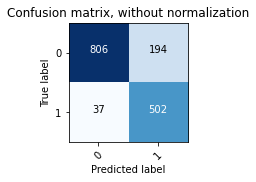

Acc     =  0.85
Pre     =  0.874
Rec     =  0.85
F1      =  0.853

Bal_Acc =  0.869
Bal_Pre =  0.721
Bal_Rec =  0.931
Bal_F1  =  0.813

              precision    recall  f1-score   support

           0       0.96      0.81      0.87      1000
           1       0.72      0.93      0.81       539

    accuracy                           0.85      1539
   macro avg       0.84      0.87      0.84      1539
weighted avg       0.87      0.85      0.85      1539

--------------------------------------------------------------------------
RF VGG19 128

Confusion matrix, without normalization


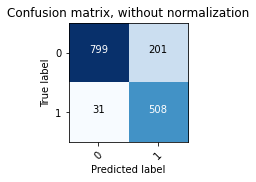

Acc     =  0.849
Pre     =  0.876
Rec     =  0.849
F1      =  0.853

Bal_Acc =  0.871
Bal_Pre =  0.717
Bal_Rec =  0.942
Bal_F1  =  0.814

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1000
           1       0.72      0.94      0.81       539

    accuracy                           0.85      1539
   macro avg       0.84      0.87      0.84      1539
weighted avg       0.88      0.85      0.85      1539

--------------------------------------------------------------------------
RF ResNet101V2 128

Confusion matrix, without normalization


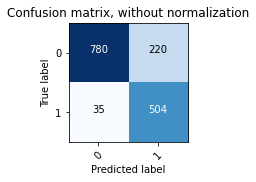

Acc     =  0.834
Pre     =  0.866
Rec     =  0.834
F1      =  0.838

Bal_Acc =  0.858
Bal_Pre =  0.696
Bal_Rec =  0.935
Bal_F1  =  0.798

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1000
           1       0.70      0.94      0.80       539

    accuracy                           0.83      1539
   macro avg       0.83      0.86      0.83      1539
weighted avg       0.87      0.83      0.84      1539

--------------------------------------------------------------------------
RF ResNet152V2 128

Confusion matrix, without normalization


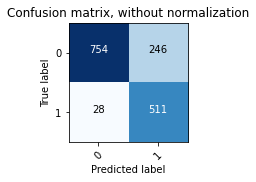

Acc     =  0.822
Pre     =  0.863
Rec     =  0.822
F1      =  0.826

Bal_Acc =  0.851
Bal_Pre =  0.675
Bal_Rec =  0.948
Bal_F1  =  0.789

              precision    recall  f1-score   support

           0       0.96      0.75      0.85      1000
           1       0.68      0.95      0.79       539

    accuracy                           0.82      1539
   macro avg       0.82      0.85      0.82      1539
weighted avg       0.86      0.82      0.83      1539

--------------------------------------------------------------------------
RF InceptionV3 128

Confusion matrix, without normalization


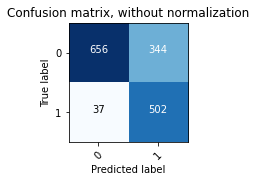

Acc     =  0.752
Pre     =  0.823
Rec     =  0.752
F1      =  0.757

Bal_Acc =  0.794
Bal_Pre =  0.593
Bal_Rec =  0.931
Bal_F1  =  0.725

              precision    recall  f1-score   support

           0       0.95      0.66      0.77      1000
           1       0.59      0.93      0.72       539

    accuracy                           0.75      1539
   macro avg       0.77      0.79      0.75      1539
weighted avg       0.82      0.75      0.76      1539

--------------------------------------------------------------------------
RF MobileNet 128

Confusion matrix, without normalization


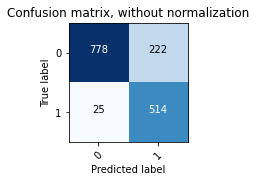

Acc     =  0.84
Pre     =  0.874
Rec     =  0.84
F1      =  0.843

Bal_Acc =  0.866
Bal_Pre =  0.698
Bal_Rec =  0.954
Bal_F1  =  0.806

              precision    recall  f1-score   support

           0       0.97      0.78      0.86      1000
           1       0.70      0.95      0.81       539

    accuracy                           0.84      1539
   macro avg       0.83      0.87      0.83      1539
weighted avg       0.87      0.84      0.84      1539

--------------------------------------------------------------------------
RF MobileNetV2 128

Confusion matrix, without normalization


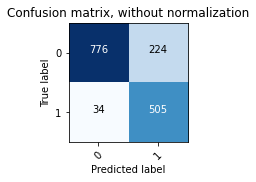

Acc     =  0.832
Pre     =  0.865
Rec     =  0.832
F1      =  0.836

Bal_Acc =  0.856
Bal_Pre =  0.693
Bal_Rec =  0.937
Bal_F1  =  0.797

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1000
           1       0.69      0.94      0.80       539

    accuracy                           0.83      1539
   macro avg       0.83      0.86      0.83      1539
weighted avg       0.87      0.83      0.84      1539

--------------------------------------------------------------------------
RF DenseNet121 128

Confusion matrix, without normalization


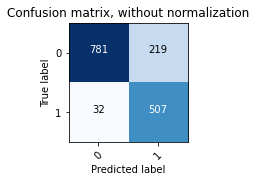

Acc     =  0.837
Pre     =  0.869
Rec     =  0.837
F1      =  0.841

Bal_Acc =  0.861
Bal_Pre =  0.698
Bal_Rec =  0.941
Bal_F1  =  0.801

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1000
           1       0.70      0.94      0.80       539

    accuracy                           0.84      1539
   macro avg       0.83      0.86      0.83      1539
weighted avg       0.87      0.84      0.84      1539

--------------------------------------------------------------------------
RF DenseNet169 128

Confusion matrix, without normalization


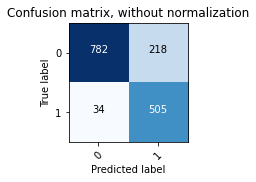

Acc     =  0.836
Pre     =  0.867
Rec     =  0.836
F1      =  0.84

Bal_Acc =  0.859
Bal_Pre =  0.698
Bal_Rec =  0.937
Bal_F1  =  0.8

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1000
           1       0.70      0.94      0.80       539

    accuracy                           0.84      1539
   macro avg       0.83      0.86      0.83      1539
weighted avg       0.87      0.84      0.84      1539

--------------------------------------------------------------------------
RF DenseNet201 128

Confusion matrix, without normalization


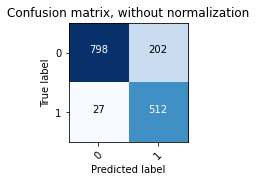

Acc     =  0.851
Pre     =  0.88
Rec     =  0.851
F1      =  0.854

Bal_Acc =  0.874
Bal_Pre =  0.717
Bal_Rec =  0.95
Bal_F1  =  0.817

              precision    recall  f1-score   support

           0       0.97      0.80      0.87      1000
           1       0.72      0.95      0.82       539

    accuracy                           0.85      1539
   macro avg       0.84      0.87      0.85      1539
weighted avg       0.88      0.85      0.85      1539

--------------------------------------------------------------------------
RF VGG16 256

Confusion matrix, without normalization


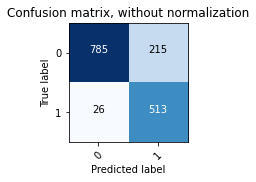

Acc     =  0.843
Pre     =  0.876
Rec     =  0.843
F1      =  0.847

Bal_Acc =  0.868
Bal_Pre =  0.705
Bal_Rec =  0.952
Bal_F1  =  0.81

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1000
           1       0.70      0.95      0.81       539

    accuracy                           0.84      1539
   macro avg       0.84      0.87      0.84      1539
weighted avg       0.88      0.84      0.85      1539

--------------------------------------------------------------------------
RF VGG19 256

Confusion matrix, without normalization


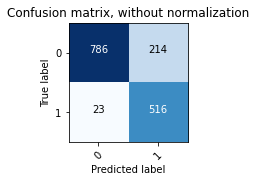

Acc     =  0.846
Pre     =  0.879
Rec     =  0.846
F1      =  0.849

Bal_Acc =  0.872
Bal_Pre =  0.707
Bal_Rec =  0.957
Bal_F1  =  0.813

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1000
           1       0.71      0.96      0.81       539

    accuracy                           0.85      1539
   macro avg       0.84      0.87      0.84      1539
weighted avg       0.88      0.85      0.85      1539

--------------------------------------------------------------------------
RF ResNet101V2 256

Confusion matrix, without normalization


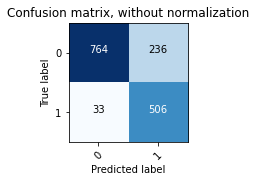

Acc     =  0.825
Pre     =  0.862
Rec     =  0.825
F1      =  0.829

Bal_Acc =  0.851
Bal_Pre =  0.682
Bal_Rec =  0.939
Bal_F1  =  0.79

              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1000
           1       0.68      0.94      0.79       539

    accuracy                           0.83      1539
   macro avg       0.82      0.85      0.82      1539
weighted avg       0.86      0.83      0.83      1539

--------------------------------------------------------------------------
RF ResNet152V2 256

Confusion matrix, without normalization


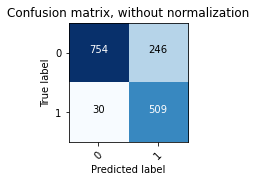

Acc     =  0.821
Pre     =  0.861
Rec     =  0.821
F1      =  0.825

Bal_Acc =  0.849
Bal_Pre =  0.674
Bal_Rec =  0.944
Bal_F1  =  0.786

              precision    recall  f1-score   support

           0       0.96      0.75      0.85      1000
           1       0.67      0.94      0.79       539

    accuracy                           0.82      1539
   macro avg       0.82      0.85      0.82      1539
weighted avg       0.86      0.82      0.82      1539

--------------------------------------------------------------------------
RF InceptionV3 256

Confusion matrix, without normalization


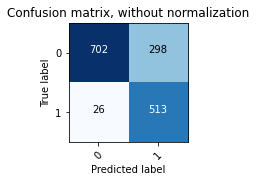

Acc     =  0.789
Pre     =  0.848
Rec     =  0.789
F1      =  0.794

Bal_Acc =  0.827
Bal_Pre =  0.633
Bal_Rec =  0.952
Bal_F1  =  0.76

              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1000
           1       0.63      0.95      0.76       539

    accuracy                           0.79      1539
   macro avg       0.80      0.83      0.79      1539
weighted avg       0.85      0.79      0.79      1539

--------------------------------------------------------------------------
RF MobileNet 256

Confusion matrix, without normalization


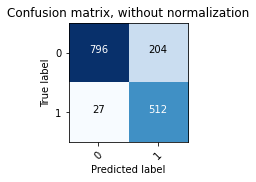

Acc     =  0.85
Pre     =  0.879
Rec     =  0.85
F1      =  0.853

Bal_Acc =  0.873
Bal_Pre =  0.715
Bal_Rec =  0.95
Bal_F1  =  0.816

              precision    recall  f1-score   support

           0       0.97      0.80      0.87      1000
           1       0.72      0.95      0.82       539

    accuracy                           0.85      1539
   macro avg       0.84      0.87      0.84      1539
weighted avg       0.88      0.85      0.85      1539

--------------------------------------------------------------------------
RF MobileNetV2 256

Confusion matrix, without normalization


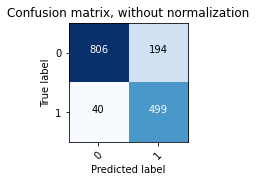

Acc     =  0.848
Pre     =  0.871
Rec     =  0.848
F1      =  0.851

Bal_Acc =  0.866
Bal_Pre =  0.72
Bal_Rec =  0.926
Bal_F1  =  0.81

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1000
           1       0.72      0.93      0.81       539

    accuracy                           0.85      1539
   macro avg       0.84      0.87      0.84      1539
weighted avg       0.87      0.85      0.85      1539

--------------------------------------------------------------------------
RF DenseNet121 256

Confusion matrix, without normalization


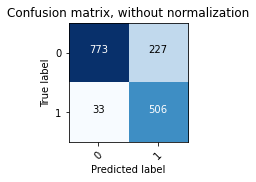

Acc     =  0.831
Pre     =  0.865
Rec     =  0.831
F1      =  0.835

Bal_Acc =  0.856
Bal_Pre =  0.69
Bal_Rec =  0.939
Bal_F1  =  0.795

              precision    recall  f1-score   support

           0       0.96      0.77      0.86      1000
           1       0.69      0.94      0.80       539

    accuracy                           0.83      1539
   macro avg       0.82      0.86      0.83      1539
weighted avg       0.86      0.83      0.83      1539

--------------------------------------------------------------------------
RF DenseNet169 256

Confusion matrix, without normalization


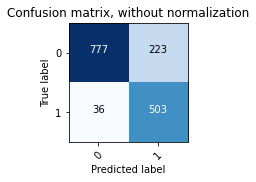

Acc     =  0.832
Pre     =  0.864
Rec     =  0.832
F1      =  0.835

Bal_Acc =  0.855
Bal_Pre =  0.693
Bal_Rec =  0.933
Bal_F1  =  0.795

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1000
           1       0.69      0.93      0.80       539

    accuracy                           0.83      1539
   macro avg       0.82      0.86      0.83      1539
weighted avg       0.86      0.83      0.84      1539

--------------------------------------------------------------------------
RF DenseNet201 256

Confusion matrix, without normalization


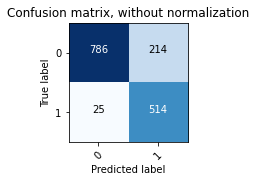

Acc     =  0.845
Pre     =  0.877
Rec     =  0.845
F1      =  0.848

Bal_Acc =  0.87
Bal_Pre =  0.706
Bal_Rec =  0.954
Bal_F1  =  0.811

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1000
           1       0.71      0.95      0.81       539

    accuracy                           0.84      1539
   macro avg       0.84      0.87      0.84      1539
weighted avg       0.88      0.84      0.85      1539



In [23]:
list_of_analysis=[]
for image_size in list_of_size:
    for model in list_of_architectures:
        for classifier in list_of_classifiers:
            print("--------------------------------------------------------------------------")
            print(classifier, model, str(image_size))
            print("")
            X_train, y_train_binary, X_test, y_test_binary = getBinaryData(model, image_size)
            X_train_SMOTE, y_train_SMOTE = getSmoteData(X_train, y_train_binary)
            prediction = classify(X_train_SMOTE, y_train_SMOTE, X_test, y_test_binary, classifier)
            accuracy, precision, recall, f1_score, balanced_accuracy, PPV, TPR, Bal_F1, TNR, NPV, FPR, FNR, FDR, Overall_Acc = getClassificationReport(y_test_binary, prediction)
            list_of_analysis.append(
                [
                 classifier, model, image_size, accuracy, precision, recall, f1_score, balanced_accuracy, PPV, TPR, Bal_F1, TNR, NPV, FPR, FNR, FDR, Overall_Acc
                ]
            )

In [24]:
list_of_analysis

[['RF',
  'VGG16',
  128,
  0.85,
  0.874,
  0.85,
  0.853,
  0.869,
  0.721,
  0.931,
  0.813,
  0.806,
  0.956,
  0.194,
  0.069,
  0.279,
  0.85],
 ['RF',
  'VGG19',
  128,
  0.849,
  0.876,
  0.849,
  0.853,
  0.871,
  0.717,
  0.942,
  0.814,
  0.799,
  0.963,
  0.201,
  0.058,
  0.283,
  0.849],
 ['RF',
  'ResNet101V2',
  128,
  0.834,
  0.866,
  0.834,
  0.838,
  0.858,
  0.696,
  0.935,
  0.798,
  0.78,
  0.957,
  0.22,
  0.065,
  0.304,
  0.834],
 ['RF',
  'ResNet152V2',
  128,
  0.822,
  0.863,
  0.822,
  0.826,
  0.851,
  0.675,
  0.948,
  0.789,
  0.754,
  0.964,
  0.246,
  0.052,
  0.325,
  0.822],
 ['RF',
  'InceptionV3',
  128,
  0.752,
  0.823,
  0.752,
  0.757,
  0.794,
  0.593,
  0.931,
  0.725,
  0.656,
  0.947,
  0.344,
  0.069,
  0.407,
  0.752],
 ['RF',
  'MobileNet',
  128,
  0.84,
  0.874,
  0.84,
  0.843,
  0.866,
  0.698,
  0.954,
  0.806,
  0.778,
  0.969,
  0.222,
  0.046,
  0.302,
  0.84],
 ['RF',
  'MobileNetV2',
  128,
  0.832,
  0.865,
  0.832,
  0.836,


In [25]:
import pandas as pd
df=pd.DataFrame(list_of_analysis, columns=[
                 "classifier",
                 "model",
                 "image_size",
                 "accuracy", 
                 "precision", 
                 "recall", 
                 "f1_score", 
                 "balanced_accuracy", 
                 "balanced_precision_PPV", 
                 "balanced_recall_TPR", 
                 "Bal_F1",
                 "TNR", 
                 "NPV", 
                 "FPR", 
                 "FNR", 
                 "FDR", 
                 "Overall_Acc"
                ])
df

,classifier,model,image_size,accuracy,precision,recall,f1_score,balanced_accuracy,balanced_precision_PPV,balanced_recall_TPR,Bal_F1,TNR,NPV,FPR,FNR,FDR,Overall_Acc
0,RF,VGG16,128,0.850,0.874,0.850,0.853,0.869,0.721,0.931,0.813,0.806,0.956,0.194,0.069,0.279,0.850
1,RF,VGG19,128,0.849,0.876,0.849,0.853,0.871,0.717,0.942,0.814,0.799,0.963,0.201,0.058,0.283,0.849
2,RF,ResNet101V2,128,0.834,0.866,0.834,0.838,0.858,0.696,0.935,0.798,0.780,0.957,0.220,0.065,0.304,0.834
3,RF,ResNet152V2,128,0.822,0.863,0.822,0.826,0.851,0.675,0.948,0.789,0.754,0.964,0.246,0.052,0.325,0.822
4,RF,InceptionV3,128,0.752,0.823,0.752,0.757,0.794,0.593,0.931,0.725,0.656,0.947,0.344,0.069,0.407,0.752
5,RF,MobileNet,128,0.840,0.874,0.840,0.843,0.866,0.698,0.954,0.806,0.778,0.969,0.222,0.046,0.302,0.840
6,RF,MobileNetV2,128,0.832,0.865,0.832,0.836,0.856,0.693,0.937,0.797,0.776,0.958,0.224,0.063,0.307,0.832
7,RF,DenseNet121,128,0.837,0.869,0.837,0.841,0.861,0.698,0.941,0.801,0.781,0.961,0.219,0.059,0.302,0.837
8,RF,DenseNet169,128,0.836,0.867,0.836,0.840,0.859,0.698,0.937,0.800,0.782,0.958,0.218,0.063,0.302,0.836
9,RF,DenseNet201,128,0.851,0.880,0.851,0.854,0.874,0.717,0.950,0.817,0.798,0.967,0.202,0.050,0.283,0.851


In [26]:
df.to_csv(analysis_output, header=True, index=False)